<a href="https://colab.research.google.com/github/rafflds/Book-Recommender-System/blob/main/Book_Recommender_System_NearestNeighbors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color=teal>Problema de Negócio

> Usaremos o método de filtragem para construir um sistema de recomendação de livros. 
> Construiremos uma máquina preditiva  com base nas leituras de outras pessoas, para que haja recomendação para cada tipo de gosto.

**Fonte dos dados**: https://www.kaggle.com/datasets/rxsraghavagrawal/book-recommender-system

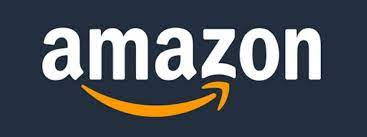

## <font color=blue>Análise Exploratória 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

### Base de livros

In [ ]:
# error_bad_lines=False (não trazer as linhas com erros)
books = pd.read_csv('BX-Books.csv', encoding='latin-1', sep=';', error_bad_lines=False)

<ipython-input-92-fad229a69479>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  books = pd.read_csv('BX-Books.csv', encoding='latin-1', sep=';', error_bad_lines=False)
b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkip

In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


### Base de Usuários

In [ ]:
users = pd.read_csv('BX-Users.csv', sep=';', encoding='latin-1', error_bad_lines=False)

<ipython-input-94-d6d1d24f540b>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  users = pd.read_csv('BX-Users.csv', sep=';', encoding='latin-1', error_bad_lines=False)


In [ ]:
users

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


### Base de Ratings (notas)

In [ ]:
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1', error_bad_lines=False)


<ipython-input-96-0359c7325bf5>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1', error_bad_lines=False)


In [ ]:
ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


## <font color=navy>Pré-Processamento dos Dados

### Renomear colunas

In [ ]:
ratings.columns

Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

In [ ]:
# Separar as variáveis a ser utilizadas
books = books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]
# Renomeá-las
books.rename(columns = {'Book-Title':'title', 'Book-Author':'author', 'Year-Of-Publication':'year', 'Publisher':'publisher'}, inplace=True)
users.rename(columns = {'User-ID':'user_id', 'Location':'location', 'Age':'age'}, inplace=True)
ratings.rename(columns = {'User-ID':'user_id',  'Book-Rating':'book_rating'}, inplace=True)

<ipython-input-99-891a53068542>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books.rename(columns = {'Book-Title':'title', 'Book-Author':'author', 'Year-Of-Publication':'year', 'Publisher':'publisher'}, inplace=True)


### Quantidade de Ratings por usuário

In [ ]:
# Usuário: 11676, avaliou mais de 13 mil livros. Verificar quem é esse usuário
ratings['user_id'].value_counts()

11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
116180        1
116166        1
116154        1
116137        1
276723        1
Name: user_id, Length: 105283, dtype: int64

### Livros que tenham mais de 200 avaliações

> Restringir a base de dados a leitores que leram uma variedade boa de livros 

In [ ]:
x = ratings['user_id'].value_counts() > 200

In [ ]:
x

11676      True
198711     True
153662     True
98391      True
35859      True
          ...  
116180    False
116166    False
116154    False
116137    False
276723    False
Name: user_id, Length: 105283, dtype: bool

### Quantidade de usuário que tem mais 200 ratings

> de 105.283 usuários, 899 deu mais 200 notas

In [ ]:
y = x[x].index
print(y.shape)

(899,)


In [ ]:
y

Int64Index([ 11676, 198711, 153662,  98391,  35859, 212898, 278418,  76352,
            110973, 235105,
            ...
            260183,  73681,  44296, 155916,   9856, 274808,  28634,  59727,
            268622, 188951],
           dtype='int64', length=899)

### Decisão de Negócio

In [ ]:
# Ratear os dados a usuários com mais 200 notas
ratings = ratings[ratings['user_id'].isin(y)]

In [ ]:
# Juntando as tabelas
rating_with_books =ratings.merge(books, on='ISBN')
rating_with_books.head()

,user_id,ISBN,book_rating,title,author,year,publisher
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc


In [ ]:
# Quantidade de ratings dos livros
number_rating = rating_with_books.groupby('title')['book_rating'].count().reset_index()

In [ ]:
number_rating

,title,book_rating
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1
...,...,...
160264,Ã?Â?ber die Pflicht zum Ungehorsam gegen den S...,3
160265,Ã?Â?lpiraten.,1
160266,Ã?Â?rger mit Produkt X. Roman.,1
160267,Ã?Â?stlich der Berge.,1


In [ ]:
# Renomear coluna 
number_rating.rename(columns = {'book_rating':'number_of_ratings'},inplace=True)

In [ ]:
# Juntando a tabela de livros com os tatings com a tabela de quantidade de ratings por livro
final_rating = rating_with_books.merge(number_rating, on='title')
final_rating.head(4)

,user_id,ISBN,book_rating,title,author,year,publisher,number_of_ratings
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,82


### Decisão de Negócio

In [ ]:
# Filtrar somente livros que tenham pelo menos 50 avaliações
final_rating = final_rating[final_rating['number_of_ratings'] >= 50]
final_rating.shape

(61853, 8)

In [ ]:
# % do filtro acima
porcento = (61853/160269)*100
print('Quantos porcentos dos dados representa o filtro %.1f' %porcento,'%')

Quantos porcentos dos dados representa o filtro 38.6 %


In [ ]:
# Descartar os valores duplicados, porque se o mesmo usuário tiver avaliado o mesmo livro 2x
final_rating.drop_duplicates(['user_id','title'],inplace=True)
final_rating.shape

<ipython-input-113-0bc4550b7209>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_rating.drop_duplicates(['user_id','title'],inplace=True)


(59850, 8)

In [ ]:
# % de valores descartados
descartados = (59850 / 618563) * 100
print('Valores duplicados descartados %.1f' %descartados,'%')

Valores duplicados descartados 9.7 %


In [ ]:
# Visualizar a base
final_rating.head(3)

,user_id,ISBN,book_rating,title,author,year,publisher,number_of_ratings
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,82


### Transpor usuários em colunas, ao invés de linhas para usar na máquina preditiva

In [ ]:
book_pivot = final_rating.pivot_table(columns='user_id', index='title',values='book_rating')

In [ ]:
book_pivot

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84 Charing Cross Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
You Belong To Me,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


### Tratar os valores NaN

In [ ]:
book_pivot.fillna(0,inplace=True)
book_pivot

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <font color=green>Criação da máquina preditiva

Usar algoritmo de vizinhos mais próximos, para agrupamento com base na **distância euclidiana**

### Matriz sparsa

> Variedade de colunas com valores '0', converter p/ matriz sparse

In [ ]:
from scipy.sparse import csr_matrix
book_sparse = csr_matrix(book_pivot)

In [ ]:
model = NearestNeighbors(algorithm='brute')
model.fit(book_sparse)

NearestNeighbors(algorithm='brute')

### Novas Predições

In [ ]:
book_pivot.head()

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0


In [ ]:
# 0 = indice do livro do title 1984
distances, suggestions = model.kneighbors(book_pivot.iloc[0, :].values.reshape(1, -1)) 

In [ ]:
# O livro que foi escolhi foi 1984, baseado nos dados desse livro ele te fará algumas sugestões
for i in range(len(suggestions)):
  print('Sugestões de livros: ',book_pivot.index[suggestions[i]])

Sugestões de livros:  Index(['1984', 'No Safe Place', 'A Civil Action', 'Foucault's Pendulum',
       'Long After Midnight'],
      dtype='object', name='title')


### Novas Predições

In [ ]:
# Hannibal
book_pivot.head(236)

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Guardian Angel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Guilty Pleasures (Anita Blake Vampire Hunter (Paperback)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Guilty as Sin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 236 = indice do livro do title Hannibal
distances, suggestions = model.kneighbors(book_pivot.iloc[236, :].values.reshape(1, -1)) 

In [ ]:
# O livro que foi escolhi foi Hannibal, baseado nos dados desse livro ele te fará algumas sugestões

for i in range(len(suggestions)):
  print('Sugestões de livros: ',book_pivot.index[suggestions[i]])

Sugestões de livros:  Index(['Hard Eight : A Stephanie Plum Novel (A Stephanie Plum Novel)',
       'Seven Up (A Stephanie Plum Novel)',
       'Hot Six : A Stephanie Plum Novel (A Stephanie Plum Novel)',
       'The Next Accident', 'The Mulberry Tree'],
      dtype='object', name='title')


### Novas Predições

In [ ]:
# Harry Potter
book_pivot.head(238)

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Guilty as Sin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H Is for Homicide (Kinsey Millhone Mysteries (Paperback)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hannibal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 238 = indice do livro do title Harry Potter
distances, suggestions = model.kneighbors(book_pivot.iloc[238, :].values.reshape(1, -1)) 

In [ ]:
# O livro que foi escolhi foi Harry Potter, baseado nos dados desse livro ele te fará algumas sugestões

for i in range(len(suggestions)):
  print('Sugestões de livros: ',book_pivot.index[suggestions[i]])

Sugestões de livros:  Index(['Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Order of the Phoenix (Book 5)',
       'The Cradle Will Fall', 'Exclusive'],
      dtype='object', name='title')
